In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import xarray as xr
print(xr.backends.plugins.list_engines())

/home/giuseppe/pmts/pmts_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'pyrregular': <IrregularEntrypoint>, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


In [3]:
# setup.py or pyproject.toml (by maintainers of pyrregular)
entry_points={
    'xarray.backends': ['pyrregular = pyrregular.backend:PyrregularBackendEntrypoint'],
}


## Loading the dataset

In [4]:
df = xr.load_dataset("/home/giuseppe/pmts/notebooks/data/PMTSA_2025.h5", engine="pyrregular")["data"]
df


Format,coo
Data Type,float64
Shape,"(40334, 34, 336)"
nnz,10486913
Density,0.02275926206997898
Read-only,True
Size,320.0M
Storage ratio,0.09


In [5]:
# the shape is (n_time_series, n_channels, n_timestamps)
df.shape

(40334, 34, 336)

In [6]:
# the array is stored as a sparse array
df.data

Format,coo
Data Type,float64
Shape,"(40334, 34, 336)"
nnz,10486913
Density,0.02275926206997898
Read-only,True
Size,320.0M
Storage ratio,0.09


### Some plots

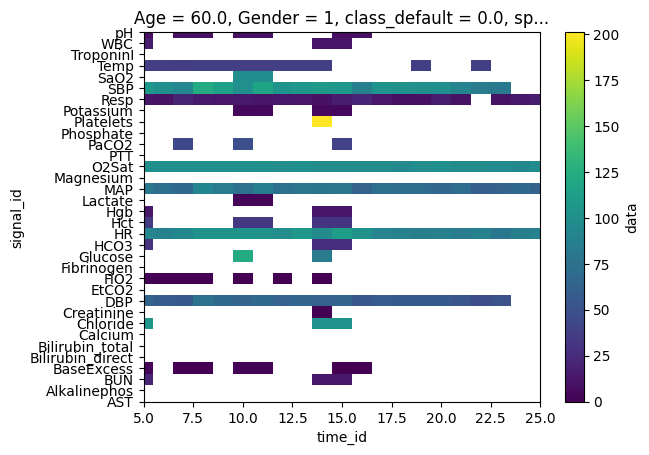

In [7]:
# plotting an entire multivariate time series
df.irr[1].plot()

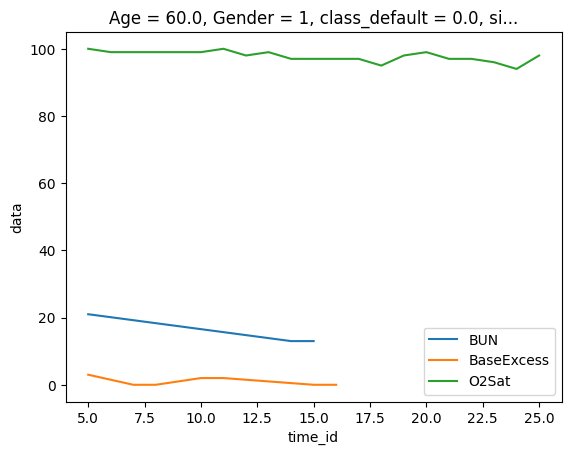

In [8]:
# plotting some channels
df.irr[1, 2].plot(label=df.coords["signal_id"][2].item())
df.irr[1, 3].plot(label=df.coords["signal_id"][3].item())
df.irr[1, 21].plot(label=df.coords["signal_id"][21].item())
plt.legend()

## Converting to dense

In [9]:
%%time
# time series data
X, _ = df.irr.to_dense()

CPU times: user 8.08 s, sys: 769 ms, total: 8.84 s
Wall time: 8.13 s


In [10]:
# static variables
Z = df.coords.to_dataset()[["Age", "Gender"]].to_pandas()
Z.head()

,Age,Gender,class_default,split_default
ts_id,,,,
0,70.0,1,NaN,test
1,60.0,1,0.0,train
2,80.0,0,NaN,test
3,30.0,1,0.0,train
4,70.0,0,0.0,train


In [11]:
# target and split
y, split = df.irr.get_task_target_and_split()

### Train-test split

In [12]:
X_train, X_test = X[split != "test"], X[split == "test"]
y_train, y_test = y[split != "test"], y[split == "test"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20336, 34, 334), (20336,), (19998, 34, 334), (19998,))

In [13]:
test_id = df["ts_id"][split == "test"].data

## Preprocessing

In [14]:
import numpy as np

In [15]:
type(X_train)

numpy.ndarray

In [16]:
print(X_train.shape)  # (n_samples, n_channels, n_timestamps)

(20336, 34, 334)


In [17]:
# For each feature count the number of NaN values
missing_counts = np.isnan(X_train).sum(axis=(0,2))
print(missing_counts)

[6780404 6780692 6727748 6709843 6791042 6782531 6752906 6726447 6739737
 6382306 6792224 6680069 6786194 6695568 6728607 6063198 6699166 6722403
 6765081 6082867 6730743 6097088 6753918 6722936 6752328 6740725 6706388
 6079267 6122210 6753064 6525323 6791259 6732876 6701609]


In [18]:
# Compute the percentage of missing values for each feature
missing_percentage = (missing_counts / (X_train.shape[0] * X_train.shape[2])) * 100
print(missing_percentage)

[ 99.82597747  99.83021761  99.05073802  98.78712775  99.98259775
  99.85729269  99.42113217  99.03158376  99.22724869  93.9648928
 100.          98.34877354  99.91122201  98.57696095  99.06338484
  89.26675563  98.62993329  98.97204509  99.60038126  89.55633678
  99.09483256  89.76570855  99.43603156  98.9798923   99.41262243
  99.24179473  98.73626076  89.50333499  90.13557268  99.42345835
  96.07049179  99.98579258  99.12623612  98.66590089]


In [19]:
# drop channels with more than 99% of missing values
threshold = 99
mask = missing_percentage < threshold
X_train_masked = X_train[:, mask, :]
X_test_masked = X_test[:, mask, :]

# check the shape of the masked data
print(X_train_masked.shape)  # (n_samples, n_channels, n_timestamps)
# check the shape of the masked data
print(X_test_masked.shape)  # (n_samples, n_channels, n_timestamps)

(20336, 15, 334)
(19998, 15, 334)


In [ ]:
from sktime.transformations.series.impute import Imputer
# replace missing values
imputer = Imputer(method="drift")
X_train_imputed = imputer.fit_transform(X_train_masked)
X_test_imputed = imputer.transform(X_test_masked)

In [ ]:
# check if there are still missing values
np.isnan(X_train_imputed).ravel().sum(), np.isnan(X_test_imputed).ravel().sum()

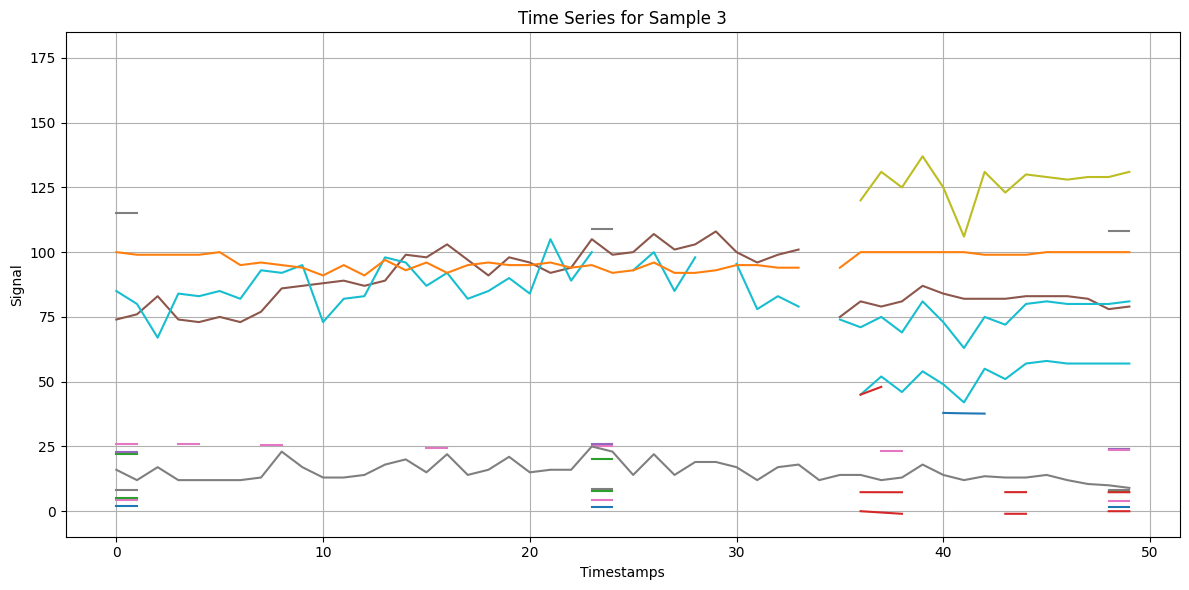

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a sample index and channel(s)
sample_idx = 3         # pick one sample
channels_to_plot = np.arange(X_train.shape[1])

# Get the time axis (assuming uniform sampling)
time = np.arange(X_train.shape[-1])

# Plot each selected channel
plt.figure(figsize=(12, 6))
for ch in channels_to_plot:
    plt.plot(time, X_train[sample_idx, ch], label=f'Channel {ch}')

plt.xlabel('Timestamps')
plt.ylabel('Signal')
plt.title(f'Time Series for Sample {sample_idx}')
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([18546,  1790]))

In [48]:
from sklearn.preprocessing import LabelEncoder
# Encode the labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
np.unique(y_train)


array([0, 1])

## Preparing a submission

In [19]:
import pandas as pd
def prepare_submission(ids, pred):
    submission = pd.DataFrame({"ID": ids, "TARGET": pred})
    return submission

In [20]:
from sktime.classification.dummy import DummyClassifier

In [21]:
clf = DummyClassifier()

In [22]:
%%time
clf.fit(X_train, y_train)

CPU times: user 24.7 s, sys: 572 ms, total: 25.3 s
Wall time: 25.5 s


DummyClassifier()

In [23]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 25.9 s, sys: 553 ms, total: 26.4 s
Wall time: 26.5 s


In [27]:
submission = prepare_submission(test_id, y_pred)
submission.to_csv("submission_GL_dummy.csv", index=False)

In [28]:
submission.head()

,ID,TARGET
0,0,0.0
1,2,0.0
2,5,0.0
3,7,0.0
4,8,0.0
